# Séries Temporais - Live Let's Data de 10/09/2021

In [1]:
# Para importar database do Kaggle, deve criar usuário no Kaggle e gerar o token de
# autenticação

import kaggle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from xgboost import XGBRegressor

In [2]:
# no windows, o token (kaggle.json), deve estar em users/<seu_usuario>/.kaggle

kaggle.api.authenticate()

In [3]:
# buscando as bases
kaggle.api.dataset_download_files('shenba/time-series-datasets', path='./data', unzip=True)

In [4]:
# vamos importar a base de produção de energia elétrica
df = pd.read_csv('./data/Electric_Production.csv', index_col='DATE', parse_dates=True)
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [5]:
# quantas linhas e colunas?
df.shape

(397, 1)

In [6]:
# Estatística descritiva
df.describe()

,IPG2211A2N
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


In [7]:
# Quando começam e terminam os dados?
df.index.min(), df.index.max()

(Timestamp('1985-01-01 00:00:00'), Timestamp('2018-01-01 00:00:00'))

In [8]:
df.columns = ['producao']

<AxesSubplot:xlabel='DATE'>

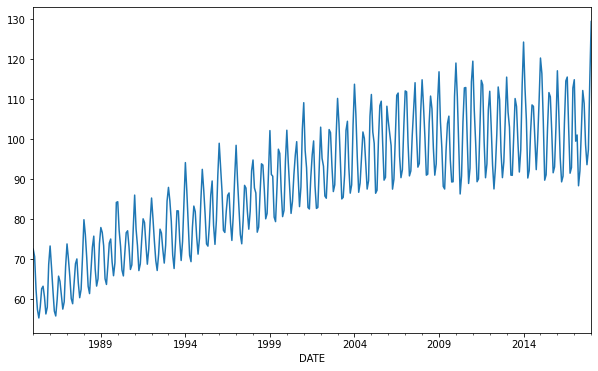

In [9]:
# Vamos dar uma olhada no gráfico de consumo x anos
df['producao'].plot(figsize=(10,6))

### Prevendo com ARIMA

notebook referencia:

https://www.kaggle.com/ludovicocuoghi/electric-production-forecast-lstm-sarima

<Figure size 576x432 with 0 Axes>

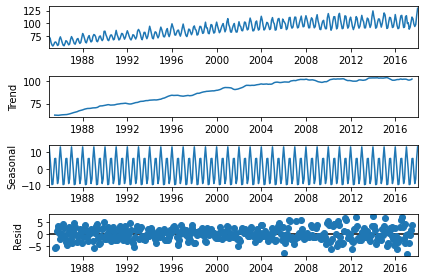

In [10]:
# Primeiro, vamos decompor a série pra avaliar tendência
# Sazonalidade e resíduo
from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(df)

fig = plt.figure(figsize=(8, 6))  
fig = resultado.plot()

#### Teste de estacionariedade

In [11]:
# Teste de estacionariedade. 
# A hipótese nula é que a série não é estacionária
# Ou seja, se o p-valor for menor que 0,05, rejeitamos
# que a série não é estacionária. Caso seja maior, não podemos
# descartar que a série não é estacionária
from statsmodels.tsa.stattools import adfuller

result=adfuller(df['producao'].dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-2.2569903500472397
p-valor:0.18621469116586947


#### Ou seja, a série não é realmente estacionária (p-valor >0.05, não podemos rejeitar a hipótese nula)

In [12]:
# Auto ARIMA nos ajuda a buscar os melhores parâmetros
fit_arima = auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, 
                           m=6, 
                           D=1, 
                           start_P=1, 
                           start_Q=1, 
                           max_P=2, 
                           max_Q=2, 
                           information_criterion='aic',
                           trace=True, 
                           error_action='ignore', 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=1912.925, Time=0.83 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=2404.500, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=1998.731, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=2057.803, Time=0.34 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=2000.250, Time=0.45 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=inf, Time=0.42 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=1880.044, Time=1.12 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=inf, Time=0.88 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=inf, Time=1.83 sec
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=inf, Time=1.34 sec
 ARIMA(0,1,1)(2,1,1)[6]             : AIC=1925.181, Time=0.66 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=1942.791, Time=0.59 sec
 ARIMA(2,1,1)(2,1,1)[6]             : AIC=1881.313, Time=1.49 sec
 ARIMA(1,1,2)(2,1,1)[6]             : AIC=1880.682, Time=1.27 sec
 ARIMA(0,1,0)(2,1,1)[6]             : AIC=1955.485, T

In [13]:
# Agora que sabemos os melhores parâmetros, vamos criar um modelo SARIMAX 
# (versão do arima com parametros para sazonalidade)

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df,order=(2,1,2),  seasonal_order=(1, 1, 2, 6))
resultado_sarimax = model.fit()

F:\leon\venvs\live02_series_temporais\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
F:\leon\venvs\live02_series_temporais\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
F:\leon\venvs\live02_series_temporais\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
F:\leon\venvs\live02_series_temporais\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [14]:
# resultados do modelo SARIMAX(2,1,2)
resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                          producao   No. Observations:                  397
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 6)   Log Likelihood                -899.089
Date:                           Wed, 22 Sep 2021   AIC                           1814.177
Time:                                   11:02:48   BIC                           1845.907
Sample:                               01-01-1985   HQIC                          1826.755
                                    - 01-01-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0873      0.350     -0.249      0.803      -0.773       0.599
ar.L2          0.2828      0.214      1.321      0.187      -0.137       0.702
ma.L1         -0.2982      0.337     -0.884      0.377      -0.960       0.363
ma.L2         -0.6397      0.329     -1.944      0.052      -1.285       0.005
ar.S.L6       -0.9976      0.003   -380.177      0.000      -1.003      -0.992
ma.S.L6        0.1145      0.040      2.832      0.005       0.035       0.194
ma.S.L12      -0.7764      0.037    -20.853      0.000      -0.849      -0.703
sigma2         5.5549      0.307     18.092      0.000       4.953       6.157
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                42.26
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.75   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
# Vamos realizar um "backtesting" com predições de valores dos 12 meses anteriores
predicoes = resultado_sarimax.get_prediction(start=-12)
predicao_media = predicoes.predicted_mean

In [16]:
# intervalo de confiança

intervalo_confianca = predicoes.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]

(103.05569549114796, 112.29472153083464)

In [17]:
predicao_media[0]

107.6752085109913

In [18]:
datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(df.index)

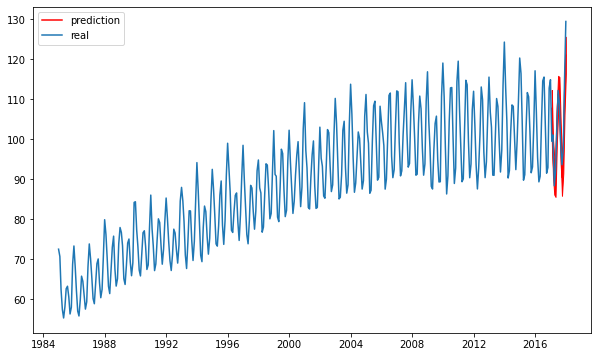

In [19]:
plt.figure(figsize=(10,6))
plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='red')
plt.plot(datas, df.values, label='real')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_sarima = sqrt(mean_squared_error(df[-12:].values,predicao_media.values))
print(rmse_sarima)

4.1932623085676095


#### FORECAST COM ARIMA

In [21]:
# Forecast pra 12 values

forecast = resultado_sarimax.get_forecast(steps=12)
forecast_medio = forecast.predicted_mean
forecast_medio.size

12

In [22]:
intervalo_confianca_forecast = forecast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forecast.iloc[:,0]
intervalo_acima_f = intervalo_confianca_forecast.iloc[:,1]

intervalo_abaixo_f[10], intervalo_acima_f[10]

(106.25355251309331, 118.06355316252821)

In [23]:
forecast_medio[10]

112.15855283781076

In [24]:
datas_forecast = np.asarray(forecast_medio.index)
pred_dates=np.asarray(predicao_media.index)

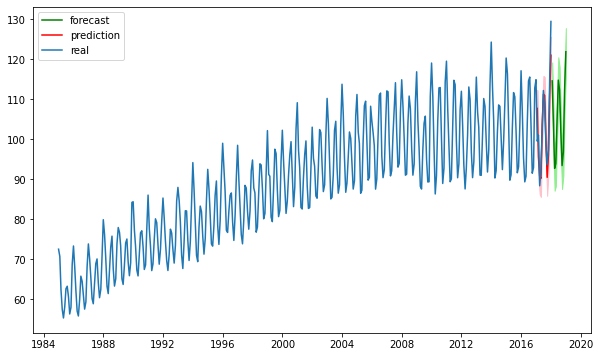

In [25]:
dates=np.asarray(df.index)
plt.figure(figsize=(10,6))
plt.plot(datas_forecast,forecast_medio.values,color='green',label='forecast')
plt.fill_between(datas_forecast, intervalo_abaixo_f, intervalo_acima_f, color='lightgreen')

plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='pink')

plt.plot(dates,df.values, label='real')
plt.legend(loc='upper left')
plt.show()

### Prevendo com XGBoost

In [26]:
df

,producao
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


In [27]:
treino = df.loc[df.index <= '2016-12-31']
validacao = df.loc[df.index > '2016-12-31']

treino.shape, validacao.shape

((384, 1), (13, 1))

In [28]:
treino.index.min(), treino.index.max()

(Timestamp('1985-01-01 00:00:00'), Timestamp('2016-12-01 00:00:00'))

In [29]:
validacao.index.min(), validacao.index.max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2018-01-01 00:00:00'))

### Criando a variavel target e a lagged variable (que já é a consumo, certo?)

In [30]:
treino['producao']

DATE
1985-01-01     72.5052
1985-02-01     70.6720
1985-03-01     62.4502
1985-04-01     57.4714
1985-05-01     55.3151
                ...   
2016-08-01    115.5159
2016-09-01    102.7637
2016-10-01     91.4867
2016-11-01     92.8900
2016-12-01    112.7694
Name: producao, Length: 384, dtype: float64

In [31]:
treino['producao'].shift(-1)

DATE
1985-01-01     70.6720
1985-02-01     62.4502
1985-03-01     57.4714
1985-04-01     55.3151
1985-05-01     58.0904
                ...   
2016-08-01    102.7637
2016-09-01     91.4867
2016-10-01     92.8900
2016-11-01    112.7694
2016-12-01         NaN
Name: producao, Length: 384, dtype: float64

In [32]:
treino['target'] = treino['producao'].shift(-1)
treino.head()

F:\leon\venvs\live02_series_temporais\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,producao,target
DATE,,
1985-01-01,72.5052,70.6720
1985-02-01,70.6720,62.4502
1985-03-01,62.4502,57.4714
1985-04-01,57.4714,55.3151
1985-05-01,55.3151,58.0904


In [33]:
treino.tail()

,producao,target
DATE,,
2016-08-01,115.5159,102.7637
2016-09-01,102.7637,91.4867
2016-10-01,91.4867,92.8900
2016-11-01,92.8900,112.7694
2016-12-01,112.7694,NaN


In [34]:
treino = treino.dropna()
treino.tail()

,producao,target
DATE,,
2016-07-01,114.5397,115.5159
2016-08-01,115.5159,102.7637
2016-09-01,102.7637,91.4867
2016-10-01,91.4867,92.8900
2016-11-01,92.8900,112.7694


In [35]:
validacao['target'] = validacao['producao'].shift(-1)
validacao.head()

F:\leon\venvs\live02_series_temporais\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,producao,target
DATE,,
2017-01-01,114.8505,99.4901
2017-02-01,99.4901,101.0396
2017-03-01,101.0396,88.3530
2017-04-01,88.3530,92.0805
2017-05-01,92.0805,102.1532


In [36]:
validacao.tail()

,producao,target
DATE,,
2017-09-01,98.6154,93.6137
2017-10-01,93.6137,97.3359
2017-11-01,97.3359,114.7212
2017-12-01,114.7212,129.4048
2018-01-01,129.4048,NaN


In [37]:
validacao = validacao.dropna()
validacao.tail()

,producao,target
DATE,,
2017-08-01,108.9312,98.6154
2017-09-01,98.6154,93.6137
2017-10-01,93.6137,97.3359
2017-11-01,97.3359,114.7212
2017-12-01,114.7212,129.4048


In [38]:
X_treino = treino.loc[:, ['producao']].values
y_treino = treino.loc[:, ['target']].values
X_validacao = validacao.loc[:, ['producao']].values
y_validacao = validacao.loc[:, ['target']].values

X_treino.shape, y_treino.shape, X_validacao.shape, y_validacao.shape

((383, 1), (383, 1), (12, 1), (12, 1))

In [ ]:
modelo_xgb_um_dia = XGBRegressor(objective="reg:squarederror", n_estimators=1000)
modelo_xgb_um_dia.fit(X_treino, y_treino)

In [ ]:
ultima_linha = treino.iloc[-1]
ultima_linha['producao']

In [ ]:
ultimo_valor_treino = np.array([ultima_linha['producao']])

In [ ]:
predicao = modelo_xgb_um_dia.predict(ultimo_valor_treino)
predicao

In [ ]:
X_validacao[0]

In [ ]:
mean_squared_error(X_validacao[0], predicao)